# Segmenting Buildings using Deep Learning

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np

import matplotlib.pyplot as plt

from torchvision import models, transforms


import imageio.v2 as imageio

import pandas as pd

from pycocotools.coco import COCO

import os


# Loading Datasets

In [79]:
import wget
import zipfile


if not os.path.exists("./dataset.zip"):  # Check if the file exists
    url = "https://www.dropbox.com/scl/fi/u3plfspdkxpxgcqt2jvkw/dataset.zip?rlkey=z82kloxfxv5jwq8k1r91bwu38&dl=1"
    filename = wget.download(url)
if not os.path.exists("./dataset"):
    with zipfile.ZipFile("./dataset.zip", 'r') as zip_ref:
        zip_ref.extractall('dataset')

# Processing Datasets

In [80]:

HEIGHT = 32
WIDTH = 32

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((HEIGHT, WIDTH)),  # Swap HEIGHT and WIDTH here
    transforms.CenterCrop((HEIGHT, WIDTH)),  # Swap HEIGHT and WIDTH here
])

class MyDataset(Dataset):
    def __init__(self, image_folder, annotation_file):
        self.coco = COCO(annotation_file)
        self.image_folder = image_folder
        self.image_ids = self.coco.getImgIds()

    def __getitem__(self, index):
        img_id = self.image_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_folder, img_info['file_name'])
        img = imageio.imread(img_path)
        img = transform(img)

        # Load the segmentation mask for the image
        mask = self.load_mask(img_info)
        mask = transforms.Resize((HEIGHT, WIDTH)).forward(mask)
        

        return {"images": img, "masks": mask}

    def load_mask(self, img_info):
        # Initialize a mask for all categories in the image with zeros
        mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

        # Load the segmentation masks for each instance in the image
        ann_ids = self.coco.getAnnIds(imgIds=img_info['id'], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            # Check if 'segmentation' is in polygon format or RLE
            if type(ann['segmentation']) == list:
                # If it's a list, assume it's polygons and convert to mask
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((int(len(seg)/2), 2))
                    mask |= self.coco.annToMask(ann)  # Use annToMask for polygons
            else:
                # If it's not a list, treat it as RLE
                mask |= self.coco.annToMask(ann)  # Directly use RLE to create mask

        # Convert the mask to a tensor
        mask = torch.as_tensor(mask, dtype=torch.float32)  # Change dtype to float32
        mask = mask.unsqueeze(0)

        return mask

    def __len__(self):
        return len(self.image_ids)


In [81]:
dataset = MyDataset("./dataset/train/", "./dataset/train/_annotations.coco.json")

loading annotations into memory...
Done (t=1.76s)
creating index...
index created!


## Display some samples from the training dataset

torch.Size([3, 32, 32]) torch.Size([1, 32, 32])


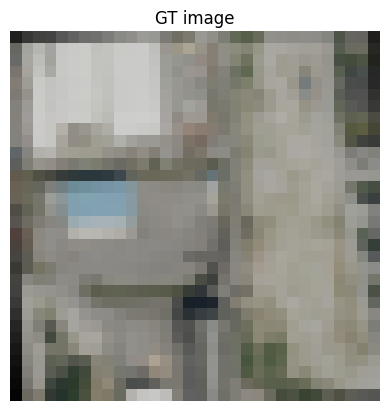

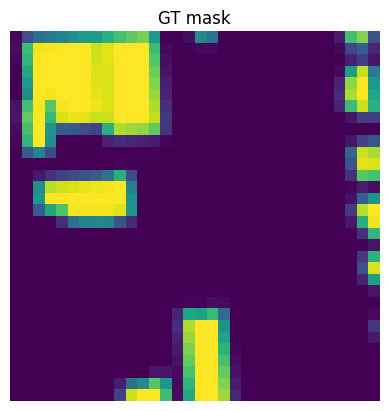

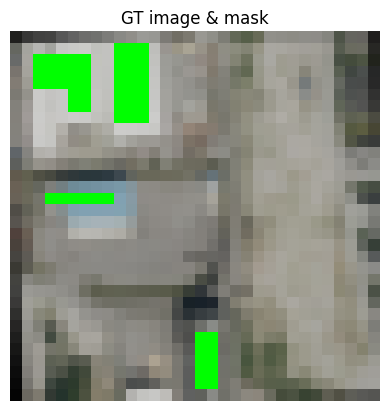

In [92]:
n = torch.randint(0, len(dataset), (1,)).item()

sample_image = dataset[n]["images"]
sample_image_mask = dataset[n]["masks"]
print(sample_image.shape, sample_image_mask.shape)

sample_image_numpy = sample_image.permute(1, 2, 0).cpu().numpy()
sample_image_mask_numpy = sample_image_mask.squeeze().cpu().numpy()


# Display the image
plt.imshow(sample_image_numpy)
plt.title("GT image")
plt.axis('off')  # Hide the axis
plt.show()

# Display the image
plt.imshow(sample_image_mask_numpy)
plt.title("GT mask")
plt.axis('off')  # Hide the axis
plt.show()

def overlay_image_mask(image, mask, title):
    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()
    if isinstance(mask, torch.Tensor):
        mask = mask.squeeze().cpu().numpy()

    # Check if image and mask have the same height and width
    if image.shape[:2] != mask.shape:
        raise ValueError("Image and mask must have the same height and width.")

    # Normalize image and mask to have pixel values between 0 and 1
    image_norm = image.astype(np.float32)
    mask_norm = mask.astype(np.float32)

    # Create a copy of the image to avoid modifying the original image
    overlapped_image = np.copy(image_norm)

    # Set mask values to overlay color (e.g., green)
    overlapped_image[mask_norm == 1] = [0, 1, 0]  # For visualization, assuming mask values of 1 indicate the region to overlay

    # Plot the overlapped image
    plt.imshow(overlapped_image)
    plt.title(title)
    plt.axis('off')
    plt.show()



overlay_image_mask(sample_image, sample_image_mask, "GT image & mask")


## Creating train dataloader

In [83]:
batch_size = 32
shuffle = True

train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [93]:
batch = next(iter(train_dataloader))

# Extract images and masks from the batch
batch_images = batch["images"]
batch_masks = batch["masks"]

batch_size = batch_images.size(0)  # Get the batch size

print(batch_size)

32


# Model

## Importing DeepLabv3+ Model

In [85]:
from models.deeplabv3plus import Model

In [86]:
from torchsummary import summary

resnet = models.resnet50(pretrained=True) # ResNet Arch
model = Model(resnet, 1)
summary(model, (3, HEIGHT, WIDTH))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
            Conv2d-2           [-1, 64, 16, 16]           9,408
       BatchNorm2d-3           [-1, 64, 16, 16]             128
       BatchNorm2d-4           [-1, 64, 16, 16]             128
              ReLU-5           [-1, 64, 16, 16]               0
              ReLU-6           [-1, 64, 16, 16]               0
         MaxPool2d-7             [-1, 64, 8, 8]               0
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]           4,096
           Conv2d-10             [-1, 64, 8, 8]           4,096
      BatchNorm2d-11             [-1, 64, 8, 8]             128
      BatchNorm2d-12             [-1, 64, 8, 8]             128
             ReLU-13             [-1, 64, 8, 8]               0
             ReLU-14             [-1, 6

In [87]:
input = batch["images"]
model(input).shape

torch.Size([32, 1, 32, 32])

# Training

In [89]:
from tqdm import tqdm


def train(model, train_dataloader, criterion, optimizer, device, epochs=1, save_path=None):
    model.train()
    model.to(device)
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch"):
            # torch.Size([32, 3, HEIGHT, WIDTH]) torch.Size([32, 1, HEIGHT, WIDTH])
            images, masks = batch["images"].to(device), batch["masks"].to(device) 
            
            optimizer.zero_grad()
            
            outputs = model(images)

            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
        
        # Save the model
        if save_path:
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            torch.save(model.state_dict(), os.path.join(save_path, f"model_epoch_{epoch+1}.pt"))


# Define the directory to save the model
save_path = "saved_models"

saved_weights_path = "saved_models/model_epoch_5.pt"  
if os.path.exists(saved_weights_path):
    model.load_state_dict(torch.load(saved_weights_path))


# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train(model, train_dataloader, criterion, optimizer, device, epochs=5, save_path=save_path)


Epoch 1/5:   0%|          | 0/423 [00:00<?, ?batch/s]C:\Users\ammar\AppData\Local\Temp\ipykernel_60180\2820321857.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)
Epoch 1/5: 100%|██████████| 423/423 [05:37<00:00,  1.26batch/s]


Epoch 1/5, Loss: 0.2816


Epoch 2/5: 100%|██████████| 423/423 [05:48<00:00,  1.22batch/s]


Epoch 2/5, Loss: 0.2750


Epoch 3/5: 100%|██████████| 423/423 [05:37<00:00,  1.25batch/s]


Epoch 3/5, Loss: 0.2704


Epoch 4/5: 100%|██████████| 423/423 [05:41<00:00,  1.24batch/s]


Epoch 4/5, Loss: 0.2658


Epoch 5/5: 100%|██████████| 423/423 [05:45<00:00,  1.22batch/s]

Epoch 5/5, Loss: 0.2609


In [94]:
import matplotlib.pyplot as plt

def test(model, test_dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)
    
    running_loss = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing", unit="batch"):
            # Move data to device
            images, masks = batch["images"].to(device), batch["masks"].to(device)
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, masks)
            running_loss += loss.item() * images.size(0)  # Multiply by batch size
            
            num_samples += images.size(0)  # Accumulate number of samples
        
        # Calculate average loss
        test_loss = running_loss / num_samples
        print(f"Test Loss: {test_loss:.4f}")

# Example usage:
# Assuming you have a test dataset named `test_dataset` and a model named `model`

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = MyDataset("./dataset/test/", "./dataset/test/_annotations.coco.json")

# Define test loader
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Test the model
test(model, test_dataloader, criterion, device)


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


Testing: 100%|██████████| 31/31 [00:14<00:00,  2.08batch/s]

Test Loss: 0.2876


## Test GT VS Generated


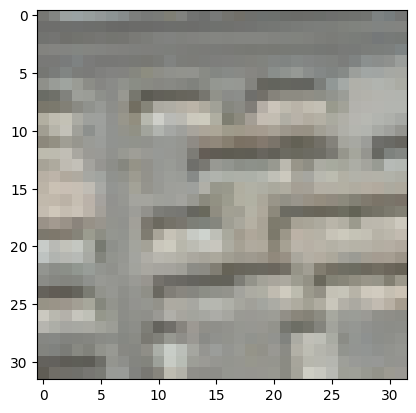

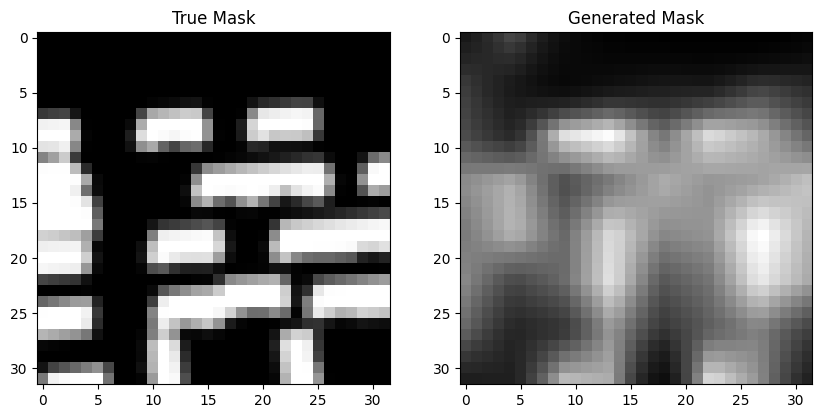

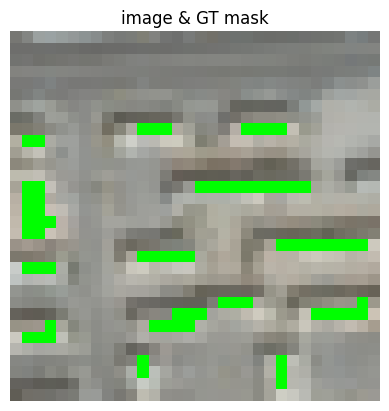

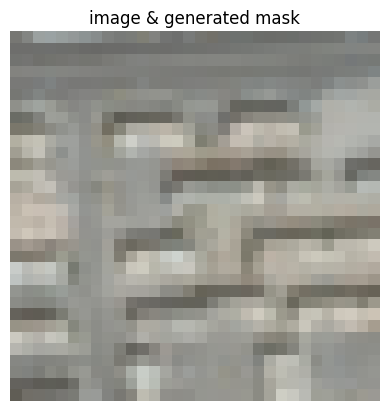

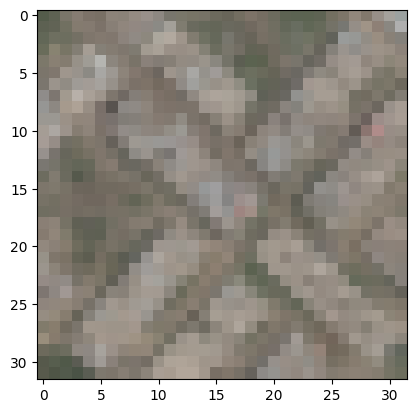

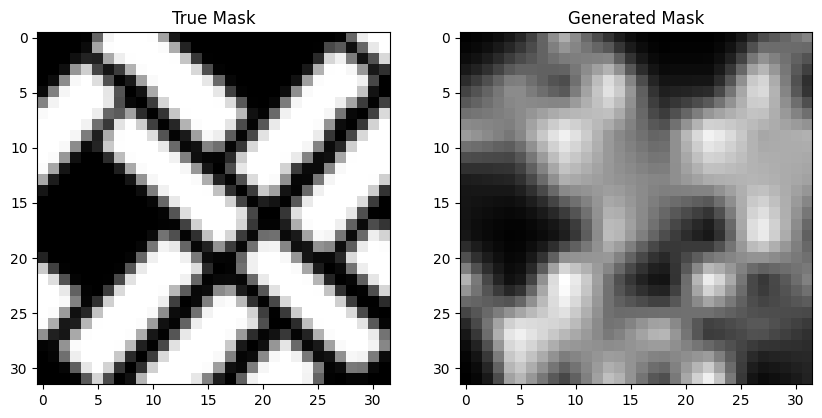

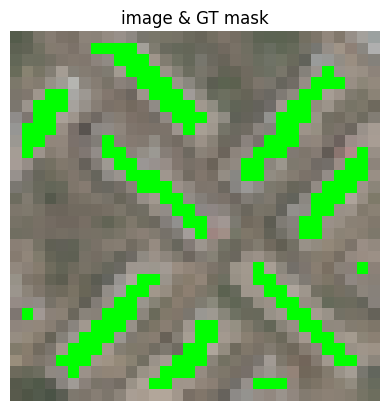

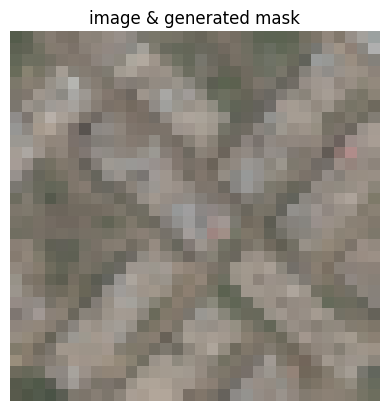

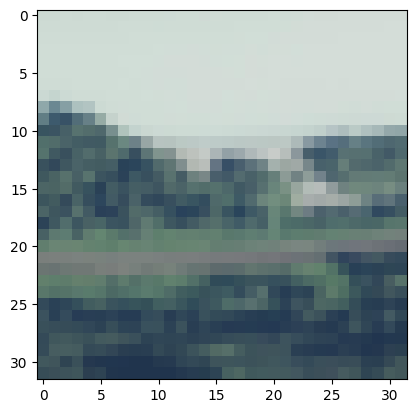

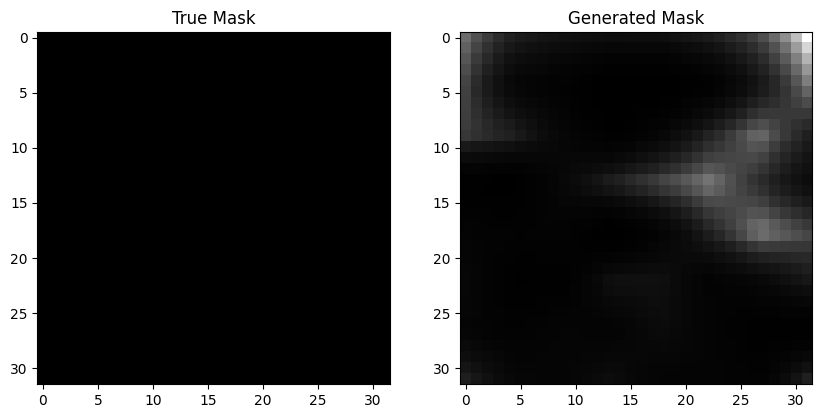

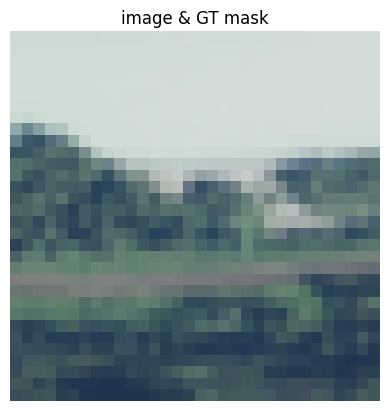

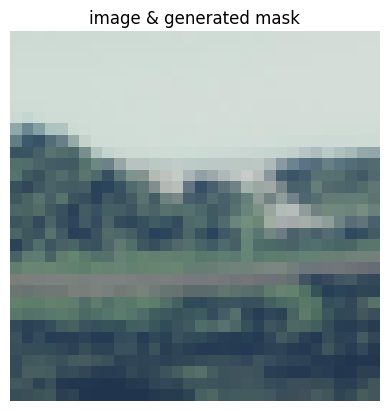

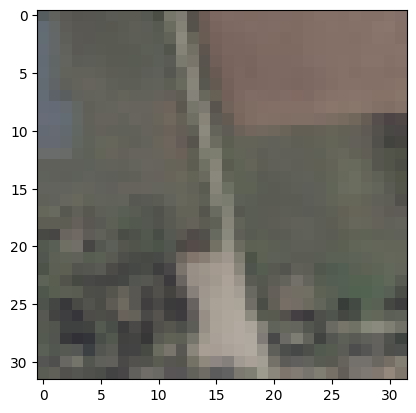

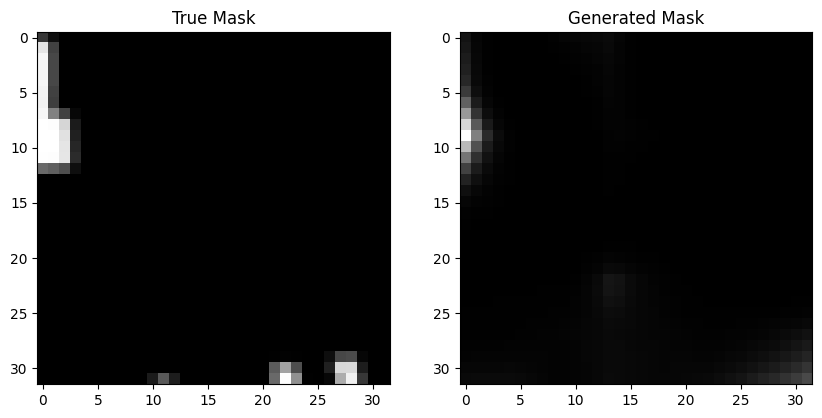

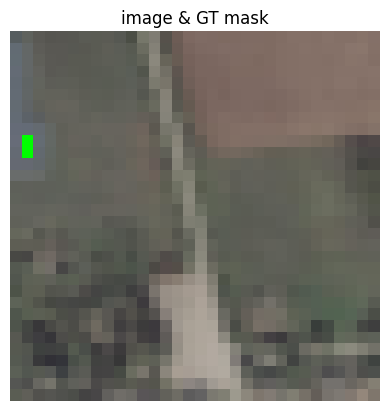

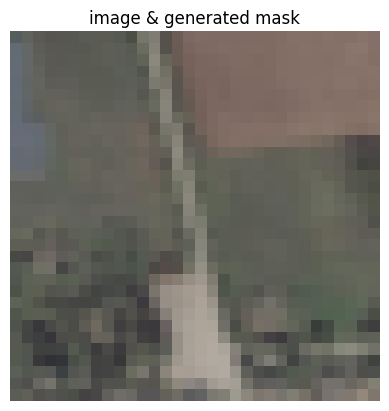

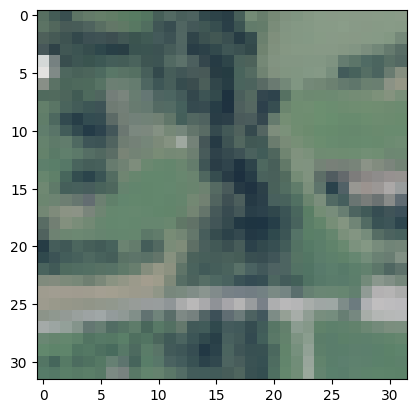

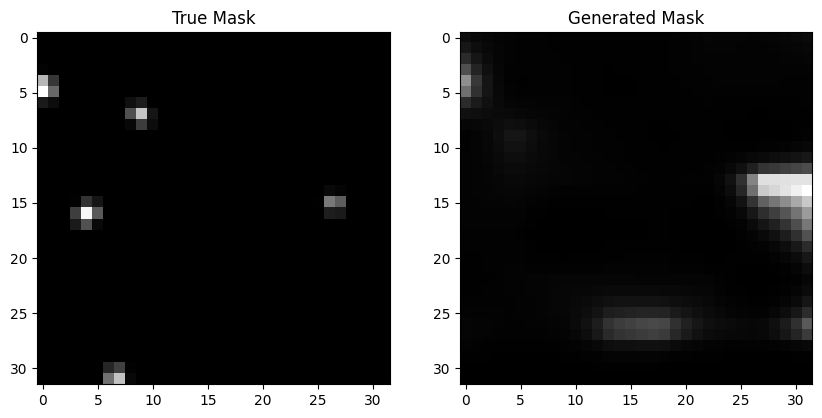

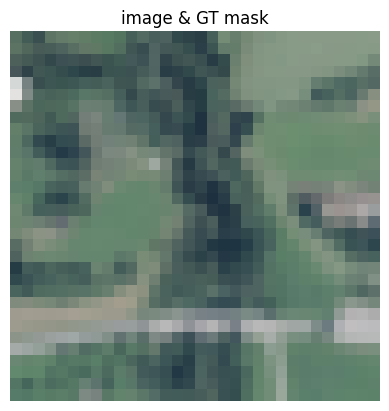

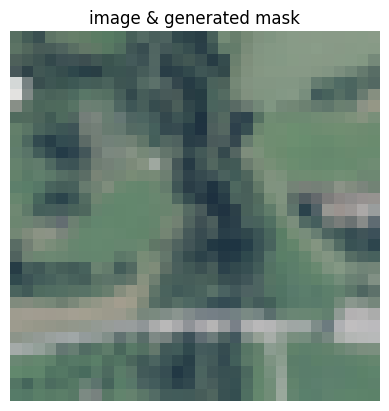

In [106]:
test_batch = next(iter(test_dataloader))
images = test_batch["images"][0:5]
GT_masks = test_batch["masks"][0:5]
generated_masks = model(test_batch["images"])[0:5]


# Convert tensors to numpy arrays
GT_masks_np = GT_masks.cpu().numpy()
# outputs_np = torch.argmax(outputs, dim=1).cpu().numpy()
generated_masks_np = generated_masks.cpu().detach().numpy()


for i in range(len(images)):
    
    # image_sample = images[i].permute(1, 2, 0).cpu().numpy()
    # plt.imshow(image_sample)
    # plt.show()
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.title("True Mask")
    # plt.imshow(GT_masks_np[i, 0], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.title("Generated Mask")
    # plt.imshow(generated_masks_np[i, 0], cmap='gray')
    # plt.show()
    overlay_image_mask(images[i], GT_masks_np[i, 0], "image & GT mask")
    overlay_image_mask(images[i], generated_masks_np[i, 0], "image & generated mask")

